In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import fastbook
fastbook.setup_book()

/home/agastya/mambaforge/lib/python3.10/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Finding edges (Kernels)
Finding edge is a common task and is generally done by appling convulotion. Convulotion uses multiplication and addition like matrix multiplication.
Convolution applies a kernel across an image. Kernel is little matrix generally 3*3

In [4]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
im3 = Image.open(path/'train'/'3'/'12.png')

In [7]:
im3_t = tensor(im3)
im3

In [8]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [9]:
# Applying conv 
(im3_t[4:7, 6:9] * top_edge).sum()

tensor(762.)

In [10]:
(im3_t[7:10, 17:20] * top_edge).sum()

tensor(-29.)

In [11]:
# Creating a function for applying conv filter
def apply_filter(row, col, edge):
    return (im3_t[row-1: row+2, col-1:col+2] * edge).sum()

In [12]:
apply_filter(8, 18, top_edge)

tensor(-29.)

### Applying conv/kernel filter to entire image

<Axes: >

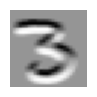

In [13]:
rng = range(1, 27)
top_edge3 = tensor([[apply_filter(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3)

<Axes: >

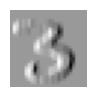

In [14]:
right_edge = tensor([[0,1,-1],
                     [0,1,-1],
                     [0,1,-1]]).float()
right_edge3 = tensor([[apply_filter(i,j, right_edge) for j in rng] for i in rng])
show_image(right_edge3)

# Convulotion in Pytorch
nn.Conv2D or nn.functional (F)\
Parameters of conv2D: (in_channels, out_channels, *)
    
    Input: Input Tensor shape [batch_size, in_channels, iH, iW]

    Weight: Filter of shape [n_out_filter, in_channels, kH, kW]

    Output: [batch_size, n_out_filters, iH (new), iW(new)]

In [15]:
# Since we can add multiple filters
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()
edge_kernels = torch.stack([top_edge, right_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [16]:
# Applying the kernel in DataLoader
DataBlock
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)
dls = mnist.dataloaders(path)

In [17]:
xb, yb = first(dls.valid)
# Input 
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [18]:
# Formatting edge kernel to in format for conv2d
# weight: [n_out_filters/n_channel_out, in_channels, kH, kW] 
edge_kernels.shape, edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [19]:
edge_kernels = edge_kernels.unsqueeze(1)

In [20]:
xb.device

device(type='cuda', index=0)

In [21]:
# xb, yb = to_cpu(xb), to_cpu(yb)
edge_kernels = edge_kernels.cuda()

In [22]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

Recieved output :\
    BS = 64\
    Kerenel/out_channels = 4\
    Image Height/Width = 26

<Axes: >

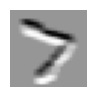

In [23]:
show_image(batch_features[0,0])

## Padding & Stride
Padding is used to add `0` element and allow us to keep our size of output activation map as same size as the orignal image.

    if kernel size is odd: Padding required ks//2

Stride is the amount by which we jump our kernel forward over the image. if move kernel by 2 pixel then it is `stride-2` convolutions
> Commonly used is ks of 3*3 and padding is 1

Using stride-2 decreases the size of the our outputs, and stride-1 are used to keep the output size the same 

---
In an image of `h` height and `w` width. Using padding of 1 & stride 1 gives output of size (h-1) & (w-1)\
In an image of `h` height and `w` width. Using padding of 1 & stride 2 gives output of size (h+1)//2 & (w+1)//2

    General Formula: (n + 2p - ks)//s + 1

# Creating First Convolution NN

- Edge filter can be created to even more degree of complexity
- Later layers in Conv kernels become complex transformation of features from lower layer
- Instead of creating these ourselves; we'll create these with SGD so that model will learn the features useful for classification 

In [24]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [25]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [26]:
print(simple_net[0])
print(simple_net[0].in_features)

Linear(in_features=784, out_features=30, bias=True)
784


In [27]:
# Creating similar architechture of linear model
# Using convolution
broken_cnn = sequential(
    nn.Conv2d(in_channels=1, out_channels=30, kernel_size=3, padding=1).to('cuda'),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)).to('cuda')

In [28]:
print(xb.shape)
broken_cnn(xb).device, broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])


(device(type='cuda', index=0), torch.Size([64, 1, 28, 28]))

- The above is not useful for classification
- Required output is single activation not an activation map
- We can perform sequential stride-2 conv to get to the final layer size of 1 

In [29]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, ks, stride=2, padding = ks//2).to('cuda')
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

When we use stride2 conv
- we increase number of filters/features at the same time
- this is because we are decreasing activation by a factor of 4
- so we don't decrease the capacity of layer too much at a time
  

In [30]:
# if image input is 28*28, then output activation for each conv layer would be
simple_cnn = sequential(   # Quick function to add args* in nn.Sequential()
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),             # Flattes the layer
)

In [31]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [32]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [33]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): fastai.layers.Flatten(full=False)
)

In [34]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.058965,0.043932,0.987733,00:04
1,0.023467,0.030219,0.990186,00:03


In [35]:
Path(path/'train'/'3').ls()

(#6131) [Path('/home/agastya/.fastai/data/mnist_sample/train/3/53838.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/44191.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/47207.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/44211.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/57952.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/31157.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/6826.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/46425.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/29045.png'),Path('/home/agastya/.fastai/data/mnist_sample/train/3/24575.png')...]

In [36]:
im3_test = Image.open(path/'train'/'3'/'59322.png')
im3_test = tensor(im3)

# Add Prediction

In [37]:
from pathlib import Path
test_imgPath = Path.cwd() 

In [38]:
!wget -O {test_imgPath}/image.png https://www.pngitem.com/pimgs/m/357-3574830_9-handwritten-hd-png-download.png

--2024-04-11 21:56:52--  https://www.pngitem.com/pimgs/m/357-3574830_9-handwritten-hd-png-download.png
Resolving www.pngitem.com (www.pngitem.com)... 204.12.226.5
Connecting to www.pngitem.com (www.pngitem.com)|204.12.226.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11509 (11K) [image/png]
Saving to: ‘/home/agastya/nbs/fastai-CNN/image.png’

/home/agastya/nbs/f 100%[===================>]  11.24K  --.-KB/s    in 0s      

2024-04-11 21:56:53 (353 MB/s) - ‘/home/agastya/nbs/fastai-CNN/image.png’ saved [11509/11509]



<Axes: >

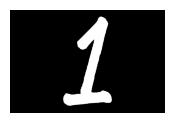

In [39]:
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
img = PILImageBW.create(test_imgPath/'image.png')
tensor(img).shape
show_image(img, figsize=(2,2))

In [40]:
dls.vocab

['3', '7']

In [41]:
img = img.resize((28, 28))  # Replace with the size used during training
dl = dls.test_dl([img])  # Create a test dataloader

preds, _, decoded_preds = learn.predict(img)
preds, _, decoded_preds

("['7', '3']", tensor([ 1.8252, -0.8823]), tensor([ 1.8252, -0.8823]))

## Understanding Conv Arithmetic

In [42]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [43]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [44]:
m[0].bias.shape

torch.Size([4])

Input Image: 28 * 28\
In layer 1 - Conv(1,4)
- weights: 1 * 4 * 3 * 3 + 4 = 40
- Output: 64, 4, 14, 14

In Layer 2 - Conv(4, 8)
- weights: 4 * 8 * 3 * 3 + 8 = 296
- Output: 64, 8, 7, 7

Multiplication between Layer 1 and 2: Activations of 1* weights in layer 2(except bias)
- 14 * 14 * 288 = 56_448

---

In Layer 3 - Conv(8, 16)
- weights: 8 * 16 * 3 * 3 + 16 = 1168       
- Output: 64, 8, 4, 4

Multiplication between Layer 2 and 3: Activations of 2* weights in layer 3(except bias)
- 7 * 7 * 1152 = 56_448


> Amount of computation stays the same. Hence we double our filters/features/channels in sride 2 conv

# Color Images

In [45]:
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

<Axes: >

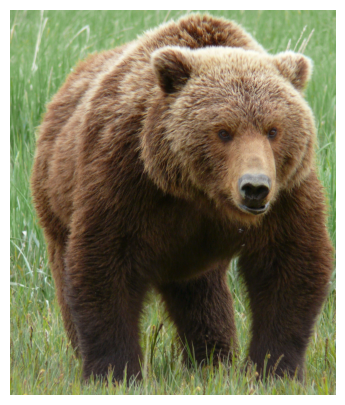

In [46]:
show_image(im)

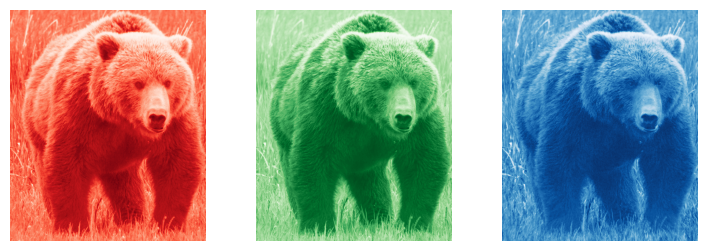

In [47]:
_, axs = subplots(1, 3)
for bear, ax, color in zip(im, axs, ('Reds', 'Greens', 'Blues')):
        show_image(255-bear, ax=ax, cmap=color)

Filter application over window:
- For all channels multiple filter can be applied
- Each filter multiplies(applied) to window of each channel by following the corresponding element
- Sum of elements accross all channels is performed to create new activation map

- First Kernel tensor should have matching number of input channels to that of image\
Kernel tensor: `Ch_in * ks * ks `\
Resultant Kernel in layers: `Ch*out * Ch_in * ks * ks ` Or N_Kernels * Kernels


## Imporoving Stability

In [48]:
path = untar_data(URLs.MNIST)
path

Path('/home/agastya/.fastai/data/mnist_png')

In [49]:
# Path.Base_PATH = path
path.ls()

(#2) [Path('/home/agastya/.fastai/data/mnist_png/testing'),Path('/home/agastya/.fastai/data/mnist_png/training')]

In [50]:
# Creating Dataloaders 
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()
                    

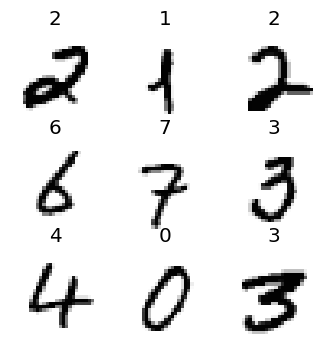

In [51]:
dls.show_batch(max_n=9, figsize=(4,4))

## Baseline

In [52]:
doc(conv)

conv(ni, nf, ks=3, act=True)
None

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


- We will need more filters as our input size is large and have more features(numbers) to learn about
- Problem: If we use 8 kernels of size of 3*3 which is applied to 9 grid pixel window only results in 8 output maps derived from 9 pixel;
  This means there is no much of learning taking place.
  > NN only creates useful feature if they're forced to do so- That is, if the `number of outputs` from operation is `significatly smaller` to the `number of inputs`
- Fix: We use 8 large kernel 5*5 for the first layer ie, 8 output map created from 25 grid pixel window 

In [53]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

`ActivationStats` callback is used to see model performance during training 

In [54]:
from fastai.callback.hook import *
def fit(epochs=1):
    learn=Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                  metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [55]:
learn = fit()

/home/agastya/mambaforge/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.307605,2.306318,0.102800,00:28


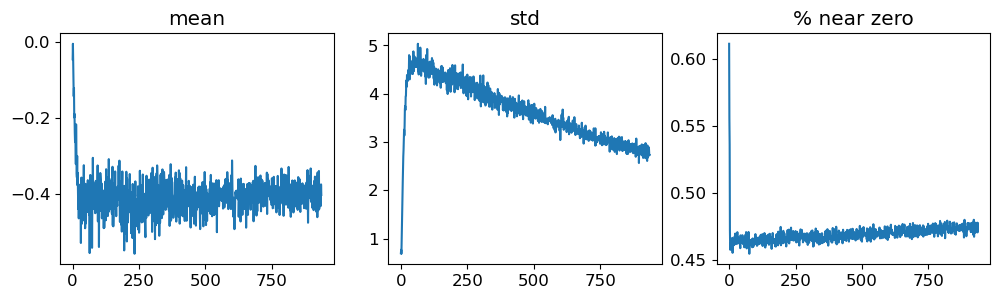

In [56]:
#First layer stats
learn.activation_stats.plot_layer_stats(0)

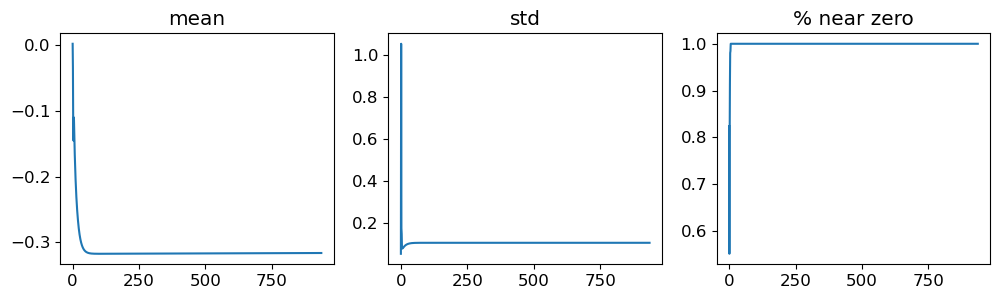

In [57]:
# Second to last layer stats
learn.activation_stats.plot_layer_stats(-2)

- We want our activation mean and std to be consisitent or smooth
- Activation % near zero gives us the idea of percentage of activations which are 0 which refrains training

## Increasing baseline

- One way to improve is to increase bs
- As larger bs have more accurate gradients
- Downside: larger batch size results in few iteration to perform backpropogation

In [58]:
dls = get_dls(512)
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.323661,2.303703,0.101000,00:20


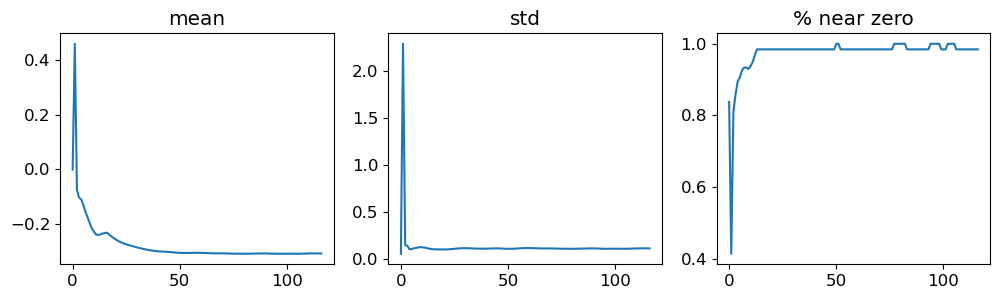

In [59]:
# No improvement
learn.activation_stats.plot_layer_stats(-2)

## 1Cycle
- Higher LR at the beginning results in diverging our training as our gradient descent would be making large jump
- Similarly, we don't want LR to be higher at end of training else we might skip a minimum
- But we want LR to be high in the middle of training to train more
- LOW LR > HIGH LR > LOW LR
    > 1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:
> - By training with higher learning rates, we train faster—a phenomenon Smith named super-convergen.
> - By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.

In [60]:
def fit(epochs=1, lr=0.06):
    learn=Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                  metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)    # This method uses 1cycle training method
    return learn
learn=fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.203891,0.073243,0.977600,00:19


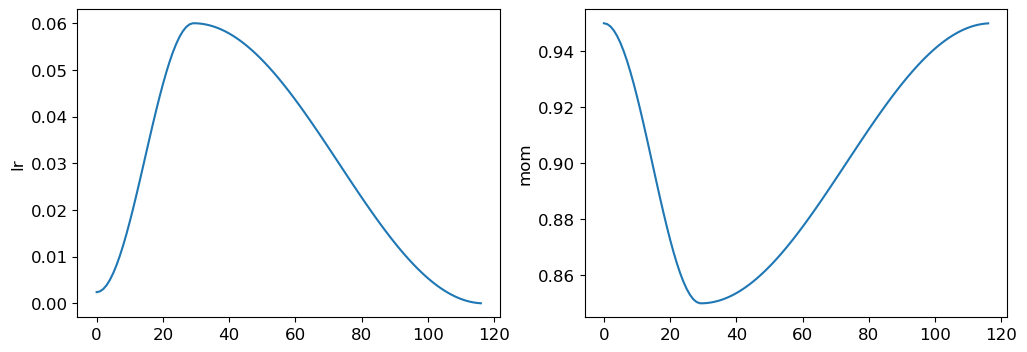

In [61]:
# Learning rate and momemtum visualization
learn.recorder.plot_sched()

- When LR is high momemtum is low and vice versa

fit_one_cycle(lr_max, div, div_final, pct_start, moms)
- div: how much to divide lr_max to get starting lr
- div_final: how much to divide lr_max to get final lr
- pct_start: what percentage of the batches to use for the warmup
- moms: a tuple(mom1, mom2, mom3) mom1(initial)->mom2->mom3(final)

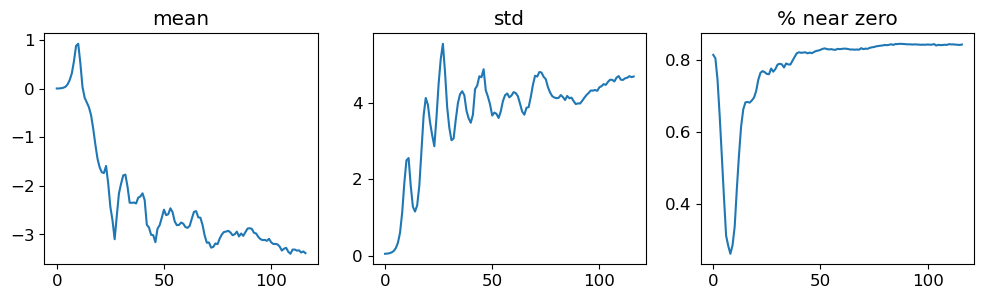

In [62]:
# Better training performance
learn.activation_stats.plot_layer_stats(-2)

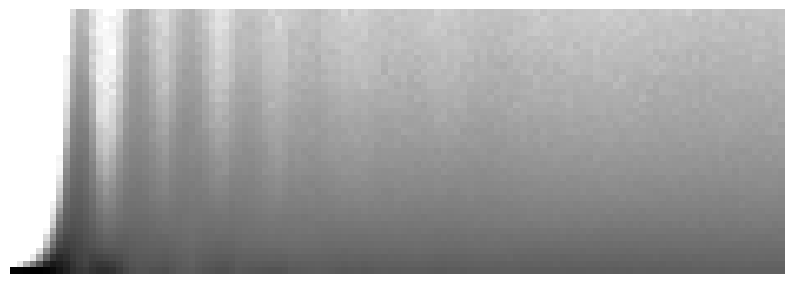

In [63]:
# another visualization
learn.activation_stats.color_dim(-2)

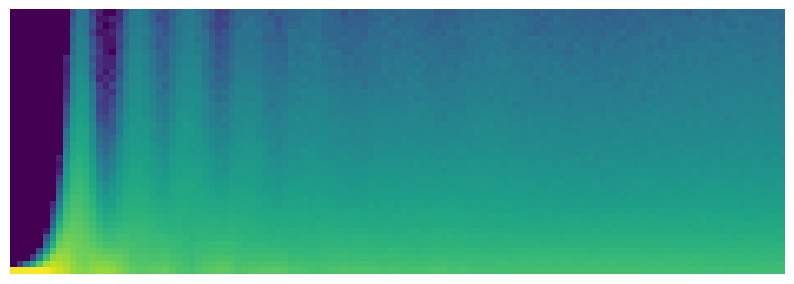

In [64]:
matplotlib.rcParams['image.cmap'] = 'viridis'
learn.activation_stats.color_dim(-2)

- Mean: Represented by the brightnes of the color
- Standard Deviation: Represented by the saturation of the color
> More saturated color -> higher variability
> Less saturated color -> lower variablility

Use case:
- if color is bright and saturated: Activations are too high, too variable and it can show exploding gradients
- if color is dark and unsaturated: Activations are low, less variable and it can be a sign of vanishing gradients

In [65]:
# Good snippet
model = simple_cnn()
stats = ActivationStats(with_hist=True)
learner = Learner(dls, model, metrics=accuracy, loss_func=F.cross_entropy, cbs=[stats])

learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.314358,0.461746,0.865400,00:20
1,0.382939,0.228710,0.930100,00:15
2,0.203077,0.155869,0.951800,00:14
3,0.152131,0.128091,0.960300,00:16
4,0.134306,0.123730,0.961900,00:14


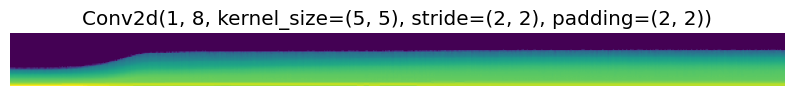

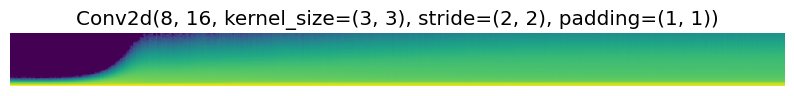

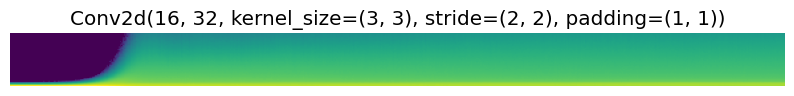

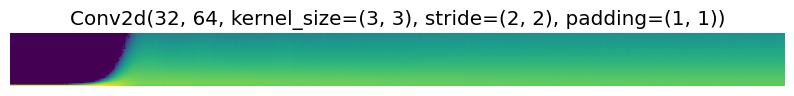

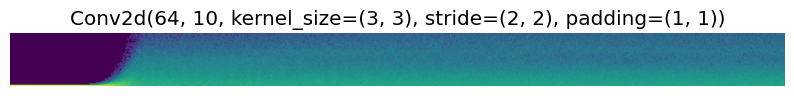

In [66]:
layers = [m for m in flatten_model(model) if has_params(m)]
for i, layer in enumerate(layers):
    fig, ax = plt.subplots(figsize=(10,32))
    ax.set_title(layer)
    stats.color_dim(i, ax=ax)

- The bottom bright yellow represent near-zero activation
- In first few batch number of non_zero activation increases exponentially
- It goes too far and collapses. 
- We again see rise in brght yellow it almost looks like retraining from scratch
- this repeats for few times and eventually activations spread throughout the range.

> To avoid this and have smooth training (beter training performance and results) we use `Batch Normalization`

## Batch Normalization (BatchNorm)
Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

- Works by taking mean and standard deviation of the activations of a layer and using those to normalize the activation.
- But this can be problematic if our desired weight is high but it gets reduce due to batch norm
- So, we add two parametes gamma * y + beta. Where y is new intermediate normalized activation and `gamma * y + beta` is output of batch norm.. 

> That's why our activations can have any mean or variance, independent from the mean and standard deviation of the results of the previous layer. Those statistics are learned separately, making training easier on our model. The behavior is different during training and validation: during training, we use the mean and standard deviation of the batch to normalize the data, while during validation we instead use a running mean of the statistics calculated during training

In [67]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [68]:
model = simple_cnn()

In [69]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.131087,0.056998,0.985200,00:21


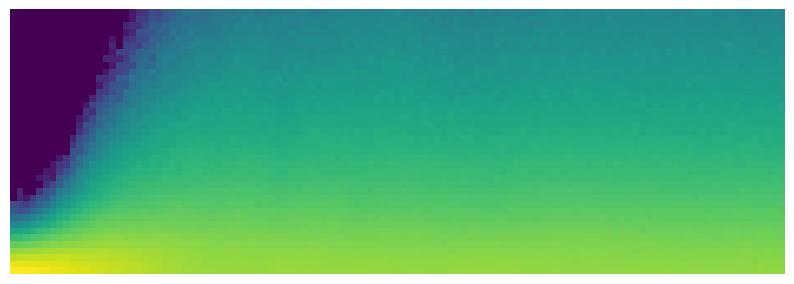

In [70]:
learn.activation_stats.color_dim(-4)

- after batchnorm: training has smooth development of the activation 
- model tends to generalize better than models not containing batch norm
- batch normalization adds some extra randomness to the training process. Each mini-batch will have a somewhat different mean and standard deviation than other mini-batches. Therefore, the activations will be normalized by different values each time.

In [ ]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.184265,0.080410,0.975500,00:22
1,0.080192,0.061428,0.982700,00:22
2,0.048218,0.048479,0.985200,00:20
